#### Variational Inference Toy example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.distributions as dist

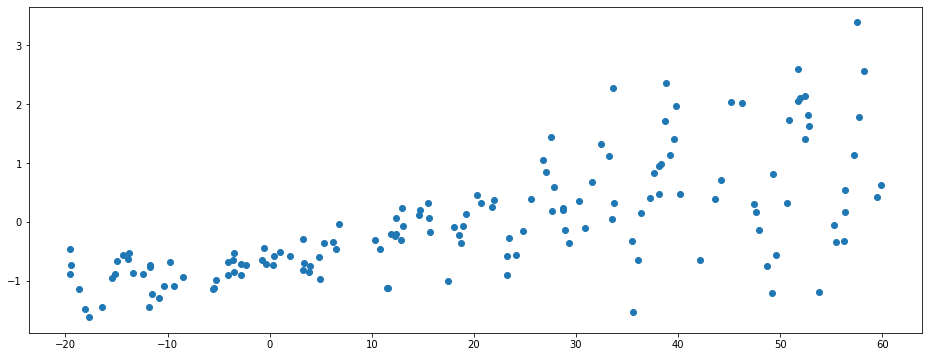

In [2]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

dataY, dataX = load_dataset()

plt.figure(figsize=(16, 6))
plt.scatter(dataX, dataY)

In [3]:
X = torch.tensor(dataX, dtype=torch.float)
Y = torch.tensor(dataY, dtype=torch.float)

In [4]:
class MaximumLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.out(x)

In [ ]:
epochs = 200
model = MaximumLikelihood()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = model(X)
    loss = (0.5 * (y_pred - Y)**2).mean()
    loss.backward()
    optim.step()

In [ ]:
with torch.no_grad():
    plt.figure(figsize=(16, 6))
    plt.plot(X.squeeze().numpy(), model(X).squeeze().numpy())
    plt.scatter(X.numpy(), dataY, alpha=0.5)

- Vanilla Nueral Net: We are able to predict the expectation of y, but we are not able to make a statement about the noise of our predictions. The outputs are point estimates.

<p>If we choose a factorized (diagonal) Gaussian variational distribution, $Q_{\theta}(y)$ becomes $Q_{\theta}(\mu, \text{diag}(\sigma^2))$. <em>Note that we are now working with an 1D case and that this factorization doesn&rsquo;t mean much right now.</em> We want this distribution to be conditioned to $x$, therefore we define a function $g_{\theta}: x \mapsto \mu, \sigma$. The function $g_{\theta}$ will be a neural network that predicts the variational parameters. </p>

In [ ]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        
    def reparameterize(self, mu, log_var):        
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps
    
    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var

$$\begin{equation}\text{ELBO} = E_{Z \sim Q}[\underbrace{\log P(D|Z)}_{\text{likelihood}}] - D_{KL}(Q(Z)||\underbrace{P(Z)}_{\text{prior}}) \label{eq:elbo} \end{equation}$$

- **Monte Carlo ELBO**: Deriving those expectations can be not possible. We can get estimates of the mean by taking samples from $Q(Z)$ and average over those results. But sampling from $Q(Z)$ is not deterministic, and the gradient can not flow. We avoid this problem by reparameterizing. Instead of sampling directly from the variational distribution, we sample from a unit gaussian and recreate samples from the variational distribution. Now the stochasticity of $\epsilon$ is external and will not prevent the flow of gradients.
$$\begin{equation} z = \mu + \sigma \odot \epsilon \end{equation}$$ where $$\space \epsilon \sim \mathcal{N}(0, 1)$$

In [ ]:
def elbo(y_pred, y, mu, log_var):
    sigma = log_var.exp()**0.5
    # likelihood of observing y given Variational mu and sigma
    likelihood = dist.Normal(mu, sigma).log_prob(y)
    
    # prior probability of y_pred
    log_prior = dist.Normal(0, 1).log_prob(y_pred)
    
    # variational probability of y_pred
    log_p_q = dist.Normal(mu, sigma).log_prob(y_pred) 
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

def det_loss(y_pred, y, mu, log_var):
    return -elbo(y_pred, y, mu, log_var)

In [ ]:
epochs = 1500

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = det_loss(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()

In [ ]:
with torch.no_grad():
    print(torch.abs(m(X)[1] - Y).mean())

In [ ]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

In [ ]:
plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X.squeeze().numpy(), mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)